# Import Required Libraries

In [1]:
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import pandas_datareader as web
plt.style.use('fivethirtyeight')

# Import Apple History Stock price from yahoo API

In [2]:
df = web.DataReader('AAPL', data_source= 'yahoo', 
                    start='2012-01-01', end = '2019-12-17')

In [3]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.650659
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.718646
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.859850
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.994284
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.973674


In [4]:
df.shape

(2003, 6)

# Plot Stock Closing Price of Apple

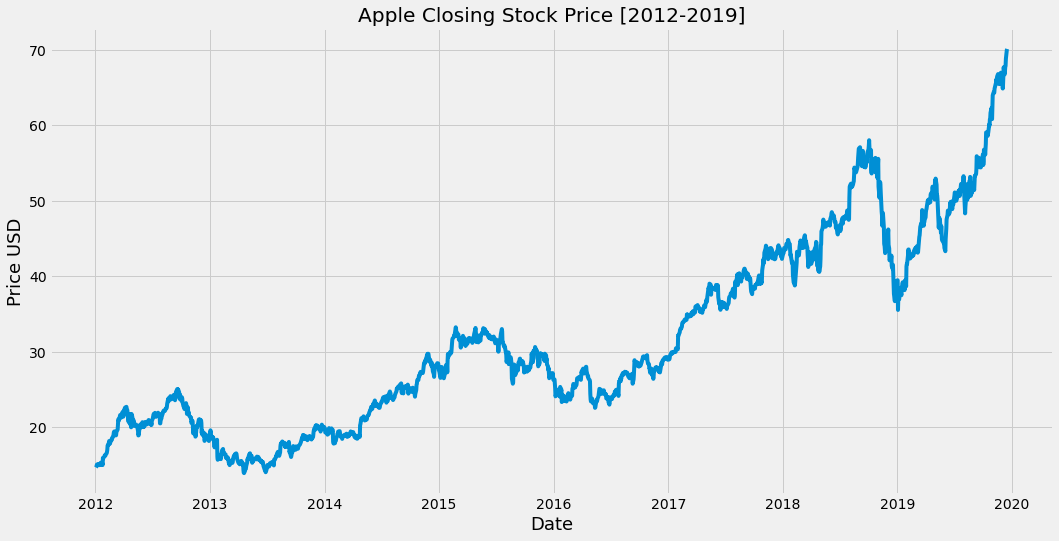

In [5]:
plt.figure(figsize=(16,8))
plt.title('Apple Closing Stock Price [2012-2019]')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD', fontsize=18)
plt.show()

# Choose Required Column to be predicted and convert to Array

In [6]:
# Create an array of only Close Price
data = df.filter(['Close'])
dataset = data.values

In [7]:
type(dataset)

numpy.ndarray

# Scale the Data between 0 and 1

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
scalled_data = scaler.fit_transform(dataset)

scalled_data

array([[0.01316509],
       [0.01457063],
       [0.01748985],
       ...,
       [0.97658263],
       [0.99755134],
       [1.        ]])

In [9]:
len(scalled_data)

2003

# Create Traning Data for Model, 80% of Dataset

In [10]:
# Create a variable to get 80% Trainig Data
train_data_len = math.ceil(len(dataset) * 0.8)
train_data_len

1603

In [11]:
# Create the Scalled training dataset
train_data = scalled_data[0:train_data_len, :]

# Create Train Data for the Model
#### Since value prediction is based on previous value, so X will be the data of past 60 days and Y will be assumed output value
#### We have selected 80% of data as train i.e. 1603
#### To train the model, we will give it X-Train and Y_Train: 
###### X_Train a set of {1603-60}=1543 individual datasets of length 60, every ith dataset of length 60 will be based on previous 60 values i.e (i-60) through 60, then another dataset 61 through 120 and so on. When complete 1543 datasets of length 60 are converted to nparray, it becomes as 2D Matrix with each row having 60 values.
###### Y_Train a list of values starting from 61st through 1603, so that the total length be 1543.

In [12]:
# Split the data into X-Train and Y-Train
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])  # Start from Past 60 Values
    y_train.append(train_data[i, 0])       # Start from 61st Value in the dataset
    if i<=61:                              # To check output of code
        print(x_train)
        print(y_train)
        print()

[array([0.01316509, 0.01457063, 0.01748985, 0.02026915, 0.01984303,
       0.02080338, 0.02036454, 0.01962679, 0.01862191, 0.02173194,
       0.02453668, 0.02367172, 0.01893355, 0.02345548, 0.01900352,
       0.03569838, 0.03440732, 0.0360927 , 0.03973694, 0.04194384,
       0.0417594 , 0.0410789 , 0.04397903, 0.04670744, 0.04979839,
       0.05479095, 0.0652785 , 0.06543749, 0.07127594, 0.07563885,
       0.06814049, 0.07102789, 0.07097066, 0.07906688, 0.07791571,
       0.08004628, 0.08387497, 0.08600558, 0.09214292, 0.09661394,
       0.09790501, 0.09835659, 0.09071194, 0.08886753, 0.08914103,
       0.09632778, 0.09835024, 0.10269409, 0.11293358, 0.12659476,
       0.12403805, 0.1240444 , 0.13392141, 0.13701237, 0.13481179,
       0.13280207, 0.13070964, 0.13766105, 0.14243103, 0.14442805])]
[0.13949272033425864]

[array([0.01316509, 0.01457063, 0.01748985, 0.02026915, 0.01984303,
       0.02080338, 0.02036454, 0.01962679, 0.01862191, 0.02173194,
       0.02453668, 0.02367172, 0.01

In [13]:
type(x_train)

list

# Convert Xtrain i.e. a list of arrays into a npArray and Ytrain from list to npArray

In [14]:
# Convert x_train and y_train to nparray to feed into LSTM Model
x_train , y_train = np.array(x_train), np.array(y_train)

In [15]:
print(type(x_train))
print(len(x_train))
print(len(y_train))

<class 'numpy.ndarray'>
1543
1543


In [16]:
x_train.shape

(1543, 60)

In [17]:
y_train.shape

(1543,)

# Reshape the data as LSTM model accepts 3D array
#### as we have x_train as 2D array, we need to convert to 3D array

In [18]:
x_train = np.reshape(x_train, 
                     newshape = (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1543, 60, 1)

# Build LSTM Model (Long Short Term Memory)

In [19]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, 
               input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

### Compile Model

In [20]:
model.compile(optimizer='adam', loss = 'mean_squared_error')

### Train the Model

In [21]:
# Train the Model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1543/1543 [==============================] - 21s 14ms/step - loss: 8.1427e-04


# Create Testing Data for the Model
#### We selected 80% of data as train i.e. 1603, so remaning data i.e {2003-1603}400 will be used as Test and Prediction
#### To test the model, we will give it X-Test and Y_Test: 
###### X_Test a set of 400 individual datasets of length 60, every ith dataset of length 60 will be based on previous 60 values i.e (i-60) through 60, then another dataset 61 through 120 and so on. When complete 400 datasets of length 60 are converted to nparray, it becomes as 2D Matrix with each row having 60 values.
###### Y_Test a list of values starting from 1603th through 2003th, so that the total length be 400.

In [22]:
# Create the testing data set
# Create new array containing scalled values from index {1603-60}1543 to 2003
test_data = scalled_data[train_data_len - 60 : , :]
print(len(test_data))

460


In [23]:
# Create datasets x_test and y_test
x_test = []                             # Will contain Scalled Values
y_test = dataset[train_data_len: , :]   # Contains Non-Scalled Values, 1603 through 2003
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60 : i, 0])

In [24]:
print(len(x_test))
print(len(y_test))

400
400


# Convert Xtest i.e. a list of arrays into a npArray and Ytest from list to npArray

In [25]:
# Convert x_test and y_test to nparray
x_test, y_test = np.array(x_test), np.array(y_test)

In [26]:
x_test.shape

(400, 60)

In [27]:
y_test.shape

(400, 1)

# Reshape the data as LSTM model accepts 3D array
#### as we have x_train as 2D array, we need to convert to 3D array

In [28]:
x_test = np.reshape(x_test, 
                   newshape = (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(400, 60, 1)

# Get the Model's Predicted Values based on XTest data

In [29]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [30]:
len(predictions)

400

# Evaluate the Model via RMSE (Root Mean Squared Error)

RMSE Formula
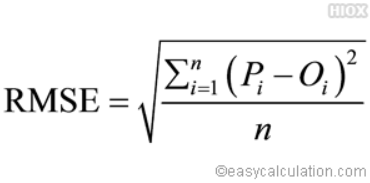

In [31]:
# Get Root Mean Squared Error (RMSE), lower the better
rmse = np.sqrt( np.mean(predictions - y_test) **2 )
print(rmse)

1.1762390422821045


# Create Datasets to plot Actual and Predicted Values side by side

In [32]:
# Plot actual plus predicted Data
train = data[ : train_data_len]
valid = data[train_data_len : ]
valid['Predictions'] = predictions

<ipython-input-32-8d2849f416e0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


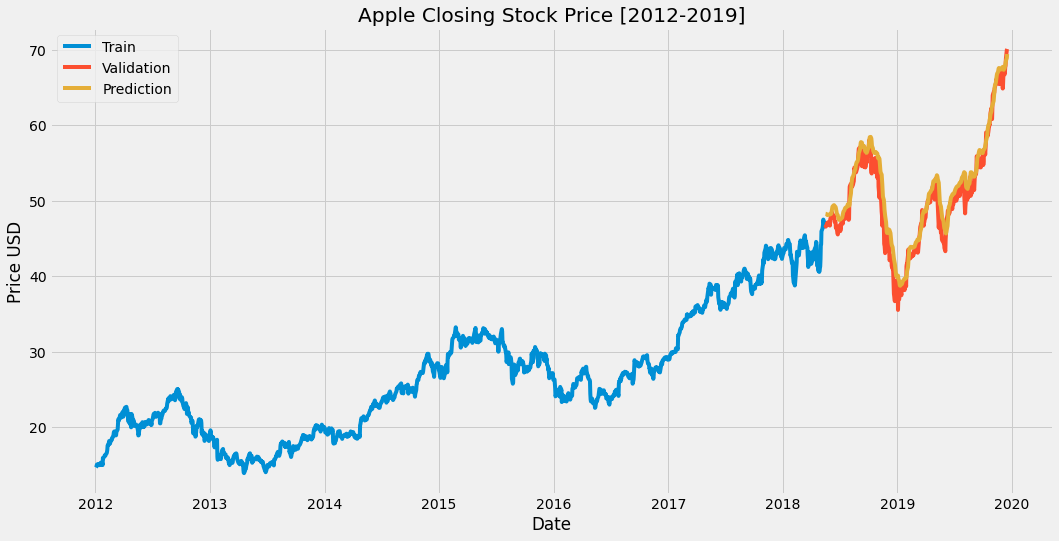

In [37]:
plt.figure(figsize = (16,8))
plt.title('Apple Closing Stock Price [2012-2019]')
plt.xlabel('Date')
plt.ylabel("Price USD")
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train','Validation','Prediction'])
plt.show()

# Predict Price of Stock on 18-Dec-2019

In [193]:
# Get the dataset
apple_q = web.DataReader('AAPL', data_source = 'yahoo', 
                         start='2012-01-01', end = '2019-12-17')

# Create DF with only Close Price Column
new_df = apple_q.filter(['Close'])

# Get Last 60 days and convert to array
last_60_days = new_df[-60: ].values

# Scale data between 0 and 1
last_60_days_scalled = scaler.fit_transform(last_60_days)

# Create a list and append last 60 days scalled to it as test data
X_test = []
X_test.append(last_60_days_scalled)

# Convert Xtest data to nparray
X_test = np.array(X_test)

# Reshape Data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get Predcited Scalled Price
pred_price = model.predict(X_test)

# Revert Scalling on Predicted Price
pred_price = scaler.inverse_transform(pred_price)

print(pred_price)

[[68.96627]]


In [173]:
apple_qa = web.DataReader('AAPL', data_source = 'yahoo', 
                         start='2019-12-18', end = '2019-12-18')
apple_qa['Close']

Date
2019-12-18    69.934998
Name: Close, dtype: float64

# Predict Price of Stock From 18-Dec-2019 to 31-Dec-2020

### Check length data points from 18-Dec-2019 to 31-Dec-2020

In [186]:
len(pd.date_range(start=pd.to_datetime("2019-12-18"), end = pd.to_datetime("2020-12-31")))

380

### Run a Loop 380 times to predict values on basis of previous 60 Values

In [190]:
last_60_days = (new_df[-60: ].values).reshape(60)

pred_list = []
for i in range(0,380):
    X_test = []
    last_60_days_scalled = scaler.fit_transform((last_60_days[-60:]).reshape((60,1)))
    X_test.append(last_60_days_scalled)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)
    
    pred_list.append(pred_price.item())
    last_60_days = np.concatenate((last_60_days,pred_price.reshape(1)))

In [191]:
len(pred_list)

380

### Create new dataframe of future dates and predicted values 

In [194]:
from datetime import timedelta
df2 = pd.DataFrame({'date': pd.date_range(start=apple_q.index[-1]+timedelta(days=1), end = pd.to_datetime("2020-12-31")), 
                    'Predictions' : pred_list})

In [195]:
df2.head()

,date,Predictions
0,2019-12-18,68.966270
1,2019-12-19,69.289993
2,2019-12-20,69.507034
3,2019-12-21,69.661003
4,2019-12-22,69.779610


In [196]:
df2.set_index('date',inplace=True)

### Append Original and Prediction Dataframes

In [197]:
apple_q = apple_q.append(df2)

### Plot Actual and Predicted Values 

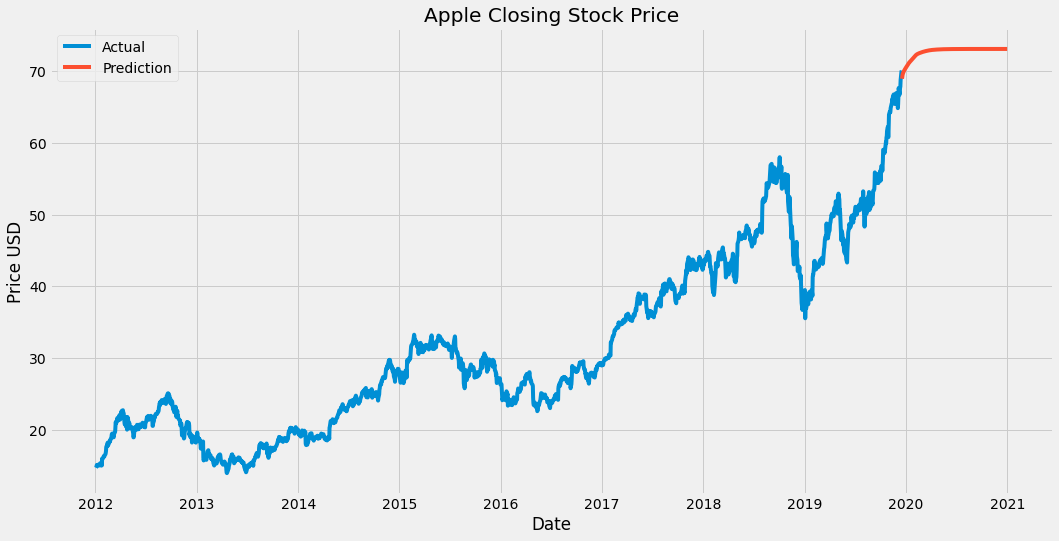

In [198]:
plt.figure(figsize = (16,8))
plt.title('Apple Closing Stock Price')
plt.xlabel('Date')
plt.ylabel("Price USD")
plt.plot(apple_q['Close'])
plt.plot(apple_q['Predictions'])
plt.legend(['Actual','Prediction'])
plt.show()